In [1]:
import bldw
import glob
import numpy as np
import blimpy as bl
import matplotlib.pyplot as plt
import setigen
import os
import turbo_seti
%matplotlib inline

# for in-line (non-terminal) turboSETI
# as in Elan Lavie's notebook
import turbo_seti.find_doppler.seti_event as turbo
import turbo_seti.find_event as find
from turbo_seti.find_doppler.find_doppler import FindDoppler
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

In [5]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc73_blp03/'
lfiles = ['blc73_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc73_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc73_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc73_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc73_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc73_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [6]:
fb = bl.Waterfall(DATADIR+lfiles[0])

In [7]:
fb.info()


--- File Info ---
DIMENSION_LABELS : [b'time' b'feed_id' b'frequency']
        az_start :                              0.0
       data_type :                                1
            fch1 :           1688.9648423530161 MHz
            foff :      -2.7939677238464355e-06 MHz
           ibeam :                                1
      machine_id :                               20
          nbeams :                                1
           nbits :                               32
          nchans :                         67108864
            nifs :                                1
     rawdatafile : guppi_58832_16209_MESSIER031_0057.0000.raw
     source_name :                       MESSIER031
         src_dej :                      41:16:03.72
         src_raj :                      0:42:44.448
    telescope_id :                                6
           tsamp :                     18.253611008
   tstart (ISOT) :          2019-12-15T04:30:09.000
    tstart (MJD) :                

In [13]:
print(np.shape(fb.grab_data()[1]))

(16, 67108864)


In [9]:
from astropy import units as u
import setigen as stg

frame = stg.Frame(fchans=1024,
                  tchans=16,
                  df=2.7939677238464355*u.Hz,
                  dt=18.253611008*u.s,
                  fch1=1501.4648451469839*u.MHz,
                  ascending=False)

In [66]:
frame_path = stg.Frame.from_waterfall(DATADIR+lfiles[0])

In [ ]:
# [111, 1743, 362]

In [67]:
signal = frame_path.add_signal(stg.constant_path(f_start=1620.123445*u.MHz,
                                            drift_rate=-2.5*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=30)),
                          stg.sinc2_f_profile(width=40*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1548.435456*u.MHz,
                                            drift_rate=2*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=20)),
                          stg.sinc2_f_profile(width=60*u.Hz),
                          stg.constant_bp_profile(level=1))

signal = frame_path.add_signal(stg.constant_path(f_start=1598.324118*u.MHz,
                                            drift_rate=1*u.Hz/u.s),
                          stg.constant_t_profile(level=frame_path.get_intensity(snr=100)),
                          stg.sinc2_f_profile(width=10*u.Hz),
                          stg.constant_bp_profile(level=1))

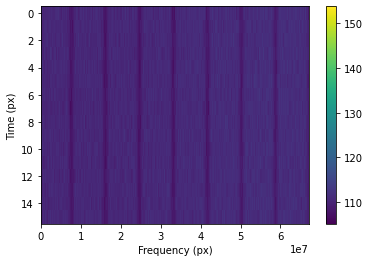

In [23]:
frame_path.plot("px")

In [68]:
wf = frame_path.get_waterfall()

In [27]:
frame_path.get_frequency(200)*1e-6

1501.4654039405286

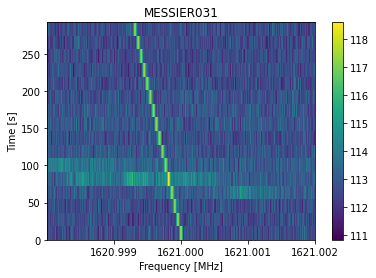

In [65]:
bw = 0.004
cf = frame_path.get_frequency(10000)*1e-6
cf = 1621
wf.plot_waterfall(f_start = cf-bw/2, f_stop = cf+bw/2, logged=True)

In [69]:
frame_path.save_fil(filename='/datax/scratch/benjb/m31_observation_with_setigen.fil')

blimpy.waterfall INFO     __write_to_fil_light: Writing the spectra matrix for /datax/scratch/benjb/m31_observation_with_setigen.fil in one go.
blimpy.waterfall INFO     Conversion time: 2.53sec


In [70]:
fb = bl.Waterfall('/datax/scratch/benjb/m31_observation_with_setigen.fil')

In [37]:
# Uncomment for copying files into scratch directory — hopefully shouldn't be necessary for en-masse runs?

for file in lfiles:
    console = f'cp {DATADIR}{file} /datax/scratch/benjb/'
    os.system(console)

In [38]:
# remove DC spikes in absence of turboSETI blank_DC option
# not needed for time-resolution spectra

data_loc = '/datax/scratch/benjb/'

for i in range(len(lfiles)):
    fb = bl.Waterfall(DATADIR + lfiles[i])
    fb.blank_dc(64)
    fb.write_to_hdf5(f'{data_loc}bDC_{lfiles[i]}')

blimpy.waterfall INFO     Conversion time: 0.15sec
blimpy.waterfall INFO     Conversion time: 0.15sec
blimpy.waterfall INFO     Conversion time: 0.15sec
blimpy.waterfall INFO     Conversion time: 0.11sec
blimpy.waterfall INFO     Conversion time: 0.11sec
blimpy.waterfall INFO     Conversion time: 0.11sec


In [75]:
print('Beginning turboSETI search (FindDoppler version) ...')

data_loc = '/datax/scratch/benjb/'

for i in range(len(lfiles)):
    doppler = FindDoppler('/datax/scratch/benjb/m31_observation_with_setigen.fil',
                      max_drift = 4,
                      snr = 10,       
                      out_dir = data_loc, # This is where the turboSETI output files will be stored.
                      n_coarse_chan = 64,
                      gpu_backend = True,
                      blank_dc = True
                     )
    doppler.search()
    break

print('Done!')


Beginning turboSETI search (FindDoppler version) ...

turbo_seti version 2.3.2
blimpy version 2.1.4
h5py version 2.10.0
hdf5plugin version 2.1.2
HDF5 library version 1.10.5


data_handler    INFO     Filterbank file detected. Attempting to create .h5 file in current directory...
blimpy.waterfall INFO     Detecting high frequency resolution data.
blimpy.waterfall INFO     __write_to_hdf5_heavy: For /datax/scratch/benjb/m31_observation_with_setigen.h5, chunk_dim=(1, 1, 1048576), blob_dim=(16, 1, 67108864), n_blobs=1
blimpy.waterfall INFO     __write_to_hdf5_heavy: Processing blob 1 of 1
data_handler    INFO     From user, n_coarse_chan=64
HDF5 header info: {'DIMENSION_LABELS': array([b'time', b'feed_id', b'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 1688.9648423530161, 'foff': -2.7939677238464355e-06, 'ibeam': 1, 'machine_id': 20, 'nbeams': 1, 'nbits': 32, 'nchans': 67108864, 'nifs': 1, 'rawdatafile': 'guppi_58832_16209_MESSIER031_0057.0000.raw', 'source_name': '

In [5]:
print('Beginning turboSETI search (command line version) ...')

for i in range(len(lfiles)):
    # Execute turboSETI in the terminal
    console = 'turboSETI ' + DATADIR + lfiles[i] + ' -M 4 -s 10 -o' + '/datax/scratch/benjb/'
    os.system(console)

print('Done!')

Beginning turboSETI search ...
Done!


In [5]:
print('Beginning plotSETI algorithm ...')

console = "plotSETI -f 3 -o " + DATADIR + " " + DATADIR
print(console)
os.system(console)

print('Done!')

Beginning plotSETI algorithm ...
plotSETI -f 3 -o /datax/scratch/benjb/m31_data/ /datax/scratch/benjb/m31_data/
Done!


In [ ]:
DATADIR = '/datag/pipeline/AGBT19B_999_121/blc75_blp05/'
lfiles = ['blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5',
'blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5',
'blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5',
'blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5',
'blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5',
'blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5']

In [8]:
# Create a simple .lst file of the .h5 files in the data directory
h5_list = sorted(glob.glob(os.path.join(DATADIR, '*.h5')))
h5_list = [DATADIR + file for file in lfiles]
    
# This writes the .h5 files into a .lst, as required by the find_event_pipeline:
h5_list_path = os.path.join(data_loc,'h5_files.lst')
with open(h5_list_path, 'w') as f:
    for h5_path in h5_list:
        f.write(h5_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(h5_list_path, 'r') as f:
    print(f.read())

/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16209_MESSIER031_0057.gpuspec.0002.h5
/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16530_HIP2792_0058.gpuspec.0002.h5
/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_16851_MESSIER031_0059.gpuspec.0002.h5
/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17168_HIP3077_0060.gpuspec.0002.h5
/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17485_MESSIER031_0061.gpuspec.0002.h5
/datag/pipeline/AGBT19B_999_121/blc72_blp02/blc72_guppi_58832_17801_HIP3223_0062.gpuspec.0002.h5



In [40]:
# Create a simple .lst file of the .dat files in the data directory
dat_list = sorted(glob.glob(os.path.join(data_loc, 'bDC_blc75*.dat')))
#dat_list = [data_loc + file[:-2] + 'dat' for file in lfiles]
    
# This writes the .dat files into a .lst, as required by the find_event_pipeline:
dat_list_path = os.path.join(data_loc, 'dat_files.lst')
with open(dat_list_path, 'w') as f:
    for dat_path in dat_list:
        f.write(dat_path + '\n')

# You don't have to print, but it's a good way to check that your list is in the correct order:
with open(dat_list_path, 'r') as f:
    print(f.read())

/datax/scratch/benjb/bDC_blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0002.dat
/datax/scratch/benjb/bDC_blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0002.dat
/datax/scratch/benjb/bDC_blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0002.dat
/datax/scratch/benjb/bDC_blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0002.dat
/datax/scratch/benjb/bDC_blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0002.dat
/datax/scratch/benjb/bDC_blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0002.dat



In [43]:
csvf_path = os.path.join(data_loc, 'blc75_found_event_table_3.csv')
find_event_pipeline(dat_list_path, 
                    #h5_list_path,
                    SNR_cut=2,
                    check_zero_drift=True,
                    filter_threshold = 3, 
                    number_in_cadence = len(dat_list), 
                    csv_name=csvf_path, 
                    saving=True)


************   BEGINNING FIND_EVENT PIPELINE   **************

Assuming the first observation is an ON
find_event_pipeline: file = bDC_blc75_guppi_58832_16209_MESSIER031_0057.gpuspec.0002.dat, tstart = 58832.18760416667, source_name = MESSIER031
find_event_pipeline: file = bDC_blc75_guppi_58832_16530_HIP2792_0058.gpuspec.0002.dat, tstart = 58832.19131944444, source_name = HIP2792
find_event_pipeline: file = bDC_blc75_guppi_58832_16851_MESSIER031_0059.gpuspec.0002.dat, tstart = 58832.19503472222, source_name = MESSIER031
find_event_pipeline: file = bDC_blc75_guppi_58832_17168_HIP3077_0060.gpuspec.0002.dat, tstart = 58832.1987037037, source_name = HIP3077
find_event_pipeline: file = bDC_blc75_guppi_58832_17485_MESSIER031_0061.gpuspec.0002.dat, tstart = 58832.202372685184, source_name = MESSIER031
find_event_pipeline: file = bDC_blc75_guppi_58832_17801_HIP3223_0062.gpuspec.0002.dat, tstart = 58832.206030092595, source_name = HIP3223
There are 6 total files in the filelist /datax/scratch/

[]

In [12]:
# and finally we plot
plot_event_pipeline(csvf_path, # full path of the CSV file built by find_event_pipeline()
                    h5_list_path, # full path of text file containing the list of .h5 files
                    filter_spec='f{}'.format(2), # filter threshold
                    user_validation=False) # Non-interactive

plot_event_pipeline: Opened file /datax/scratch/benjb/m31_data/found_event_table.csv
plot_event_pipeline: file = blc71_guppi_58832_16209_MESSIER031_0057.gpuspec.0000.h5, tstart = 58832.18760416667, source_name = MESSIER031
plot_event_pipeline: file = blc71_guppi_58832_16530_HIP2792_0058.gpuspec.0000.h5, tstart = 58832.19131944444, source_name = HIP2792
plot_event_pipeline: file = blc71_guppi_58832_16851_MESSIER031_0059.gpuspec.0000.h5, tstart = 58832.19503472222, source_name = MESSIER031
plot_event_pipeline: file = blc71_guppi_58832_17168_HIP3077_0060.gpuspec.0000.h5, tstart = 58832.1987037037, source_name = HIP3077
plot_event_pipeline: file = blc71_guppi_58832_17485_MESSIER031_0061.gpuspec.0000.h5, tstart = 58832.202372685184, source_name = MESSIER031
plot_event_pipeline: file = blc71_guppi_58832_17801_HIP3223_0062.gpuspec.0000.h5, tstart = 58832.206030092595, source_name = HIP3223
Plotting some events for:  MESSIER031
There are 2 total events in the csv file /datax/scratch/benjb/m31_

In [10]:
import glob
print(glob.glob('/home/obs/turboseti/AGBT19B_999_121/blc71_blp01/blc71_guppi_*.gpuspec.0000/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000.dat')[0])

/home/obs/turboseti/AGBT19B_999_121/blc71_blp01/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000/blc71_guppi_58832_09716_NGC7640_0037.gpuspec.0000.dat
